In [5]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

# Toy Example

$$ S + I \to I + I, c_1x_Sx_I $$
$$ I \to S, c_2x_I $$
with parameters $c_1 = 0.008, c_2=0.1.$

For $\tau$-leaping we use $\tau = 0.3$ for $T = 50$.

## Tau Leaping

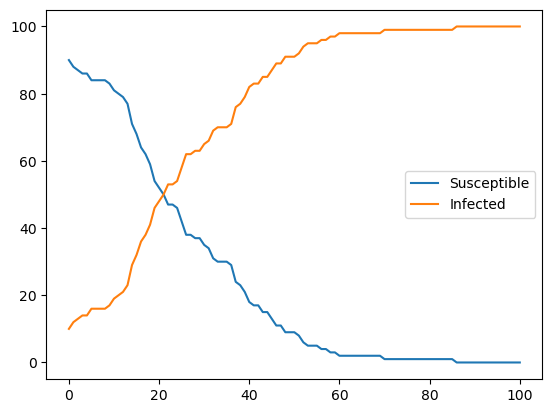

In [30]:
def tau_leaping(S, c, X0, T, tau):
    """
    S: Stoichiometry matrix. Each row represents a reaction, and each column represents a species.
    c: Array of reaction rates.
    X0: Initial state.
    T: Total time.
    tau: Leap size.
    """
    t = 0.0
    X = []
    X.append(X0)
    i = 0

    for j in range(T):
        a = c*np.array([X[i][0]*X[i][1], X[i][0]])  # Propensity function
        K = np.random.poisson(a * tau)  # Number of reactions
        X_new = X[i] + np.dot(K, S)  # Update the state
        X.append(X_new)
        t += tau  # Update the time
        i = i+1

        # Check for negative populations
        if np.any(X[i] < 0):
            raise ValueError("Negative population")

    return X

# Example usage:
S = np.array([[-1, 1], [-1, 1]])  # Stoichiometry matrix
c = np.array([0.008, 0.1])  # Reaction rates
X0 = np.array([90, 10])  # Initial state
T = 100  # Total time
tau = 0.1  # Leap size

X = tau_leaping(S, c, X0, T, tau)
plt.plot(range(len(X)), np.array(X)[:,0], label='Susceptible')
plt.plot(range(len(X)), np.array(X)[:,1], label='Infected')
plt.legend()

## SOGA - Gaussian Approx.

In [6]:
compiledFile=compile2SOGA('../programs/SOGA/SSA/SI.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

C:\Users\birik\github\SOGA4SSA\src\libSOGAupdate.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  pois_it[k_val] = 1 - norm.cdf(-muprime/pois_sigma)
C:\Users\birik\github\SOGA4SSA\src\libSOGAupdate.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  pois_it[k_val] = muprime*pois_it[k_val-1] + pois_sigma*norm.pdf(-muprime/pois_sigma)


Computed in 0.979s


In [24]:
xs = np.zeros(50)
xi = np.zeros(50)
stds = np.zeros(50)
stdi = np.zeros(50)

for i in range(50):
    idxs = output_dist.var_list.index('susceptible[{}]'.format(i))
    idxi = output_dist.var_list.index('infected[{}]'.format(i))
    xs[i] = output_dist.gm.mean()[idxs]
    stds[i] = np.sqrt(output_dist.gm.cov()[idxs,idxs])
    xi[i] = output_dist.gm.mean()[idxi]
    stdi[i] = np.sqrt(output_dist.gm.cov()[idxi,idxi])

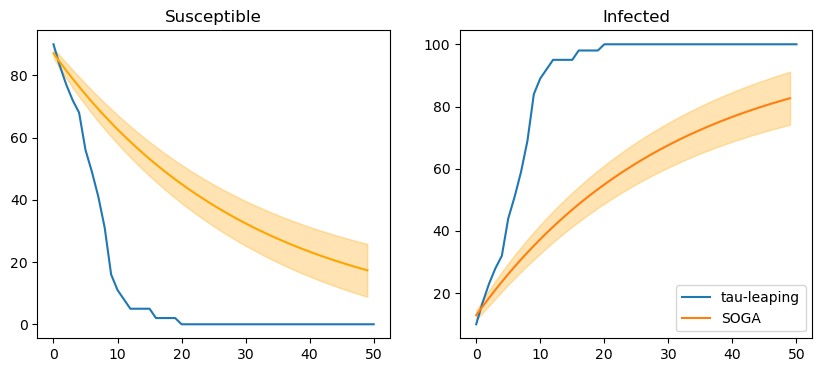

In [29]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(range(len(X)), np.array(X)[:,0], label='tau-leaping')
axs[0].plot(range(50), xs, label='SOGA', color='orange')
axs[0].fill_between(range(50), xs-stds, xs+stds ,alpha=0.3, color='orange')
axs[0].set_title('Susceptible')

axs[1].plot(range(len(X)), np.array(X)[:,1], label='tau-leaping')
axs[1].plot(range(50), xi, label='SOGA')
axs[1].fill_between(range(50), xi-stdi, xi+stdi ,alpha=0.3, color='orange')
axs[1].set_title('Infected')

axs[1].legend()